In [13]:
import pandas as pd
from tensorflow import keras
import tensorflow as tf
import random
from sklearn.utils import shuffle
import scipy.stats
from sklearn.model_selection import train_test_split

In [14]:
import time
from tensorflow.keras import layers, regularizers
from tensorflow.keras.utils import to_categorical
import numpy as np

In [15]:
import os
import shutil
from scipy import io #for loadmat, matlab conversion
import numpy as np
import matplotlib.pyplot as plt # for plotting training curves
#from tensorflow import keras #added to save model
from tensorflow.keras import layers #format matches MNIST example
#imports for computing and displaying output metrics
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support

In [16]:
def process_eeg_data(x, y):
    new_x =[]
    new_y = []
    split_size = 178
    n_splits = 23
    for i in range(x.shape[0]):
        sub_data = x[i]
        y_val = y[i]
        for i in range (n_splits):
            sample = sub_data[i*split_size:(i+1)*split_size]
            new_x.append(sample)
            temp_y = y_val
            new_y.append(temp_y)
            #print(sample.shape)
            
    new_x = np.array(new_x)
    new_y = np.array(new_y)
    # x = new_x
    # y = new_y
    return new_x, new_y

In [17]:
def load_eeg_data():
    input_dir = 'eeg_dataset_1/'
    x_train = np.load(input_dir +'x_train.npy')
    x_validation = np.load(input_dir +'x_valid.npy')
    x_test = np.load(input_dir +'x_test.npy')
    y_train = np.load(input_dir +'y_train.npy')
    y_validation = np.load(input_dir +'y_valid.npy')
    y_test = np.load(input_dir +'y_test.npy')
    
    x_train = x_train.astype(float)
    x_validation = x_validation.astype(float)
    x_test = x_test.astype(float)
    
    x_train, y_train = process_eeg_data(x_train, y_train)
    x_validation, y_validation = process_eeg_data(x_validation, y_validation)
    x_test, y_test = process_eeg_data(x_test, y_test)
    
    
    return x_train, y_train, x_validation, y_validation, x_test, y_test

In [18]:
x_train, y_train, x_validate, y_validate, x_test, y_test \
                             = load_eeg_data()

In [19]:
print(x_train.shape, y_train.shape)
print(x_validate.shape, y_validate.shape)
print(x_test.shape, y_test.shape)

(6900, 178, 1) (6900, 2)
(2300, 178, 1) (2300, 2)
(2300, 178, 1) (2300, 2)


In [20]:
def cnn_model_1(x_train, y_train, n_filters):
    n_timesteps, n_features, n_outputs = x_train.shape[1], x_train.shape[2], y_train.shape[1]
    model = keras.Sequential(
        [
            keras.Input(shape=(n_timesteps,n_features)),
            layers.Conv1D(filters=n_filters, kernel_size=1, activation='relu'),
            #layers.Conv1D(filters=n_filters, kernel_size=1, activation='relu'),
            layers.Dropout(0.1),
            layers.MaxPooling1D(pool_size=2),
            layers.Flatten(),
            layers.Dense(100, activation='relu'),
            layers.Dense(n_outputs, activation='softmax')
        ]
    )
    #model.summary()
    return model

In [21]:
filter_arr = [10, 20, 30, 50, 100, 200, 500, 1000]
BATCH_SIZE = 32     # Typical values are 8, 16 or 32
NUM_EPOCHS = 30
val_acc_arr = []
pred_acc_arr = []
time_arr = []
keras.backend.clear_session()
for n_filters in filter_arr:
    model = cnn_model_1(x_train, y_train, n_filters)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    print(model.summary())
    start = time.time()
    history = model.fit(
            x_train,y_train,
            steps_per_epoch=x_train.shape[0]//BATCH_SIZE,
            epochs=NUM_EPOCHS,
            validation_data=(x_validate,y_validate),
            validation_steps=x_validate.shape[0]//BATCH_SIZE)
    
    print("Final Validation Accuracy: %0.3f" % history.history['val_accuracy'][-1])
    end = time.time()
    predictions = model.predict(x_test, verbose=0,batch_size=32)
    
    #must use values not one-hot encoding, use argmax to convert
    y_pred = np.argmax(predictions, axis=-1) # axis=-1 means last axis
    y_test_act = np.argmax(y_test, axis=-1) # undo one-hot encoding
    
    # Print print prediction accuracy
    print('Num filters: ',n_filters)
    print('Prediction accuracy: {0:.3f}'.format(accuracy_score(y_test_act, y_pred)))
    print('Time in sec: ' ,end-start)
    val_acc_arr.append(history.history['val_accuracy'][-1])
    pred_acc_arr.append(accuracy_score(y_test_act, y_pred))
    time_arr.append(end-start)
    
    keras.backend.clear_session()
    

2024-04-26 23:01:13.280128: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 178, 10)        │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 178, 10)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 89, 10)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 890)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        89,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89,322 (348.91 KB)

 Trainable params: 89,322 (348.91 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
196/215 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6301 - loss: 7.6633

2024-04-26 23:01:14.487928: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/tljh/user/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-04-26 23:01:14.680788: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6362 - loss: 7.3072 - val_accuracy: 0.7591 - val_loss: 0.9580
Epoch 2/30
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8335 - loss: 0.5268 - val_accuracy: 0.8591 - val_loss: 0.5790
Epoch 3/30
 24/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9135 - loss: 0.4211 

2024-04-26 23:01:15.212711: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:01:15.296397: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9193 - loss: 0.3443 - val_accuracy: 0.8770 - val_loss: 0.4837
Epoch 4/30
 25/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9498 - loss: 0.2515 

2024-04-26 23:01:15.808101: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:01:15.902942: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9443 - loss: 0.2580 - val_accuracy: 0.9048 - val_loss: 0.4527
Epoch 5/30
 25/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9643 - loss: 0.2045 

2024-04-26 23:01:16.378292: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:01:16.452912: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9586 - loss: 0.2032 - val_accuracy: 0.9057 - val_loss: 0.4247
Epoch 6/30
 26/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9666 - loss: 0.1747 

2024-04-26 23:01:16.939877: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:01:17.023210: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9640 - loss: 0.1704 - val_accuracy: 0.9148 - val_loss: 0.4448
Epoch 7/30
 25/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9780 - loss: 0.1441 

2024-04-26 23:01:17.500725: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:01:17.579549: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9690 - loss: 0.1536 - val_accuracy: 0.9161 - val_loss: 0.3335
Epoch 8/30
 26/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9799 - loss: 0.1075 

2024-04-26 23:01:18.097043: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:01:18.177941: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9771 - loss: 0.1227 - val_accuracy: 0.9274 - val_loss: 0.3852
Epoch 9/30
 29/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9703 - loss: 0.1026 

2024-04-26 23:01:18.616589: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:01:18.702926: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9791 - loss: 0.0915 - val_accuracy: 0.9365 - val_loss: 0.3294
Epoch 10/30
 20/215 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9859 - loss: 0.0847 

2024-04-26 23:01:19.138088: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:01:19.227638: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9795 - loss: 0.1056 - val_accuracy: 0.9426 - val_loss: 0.2717
Epoch 11/30
 26/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9817 - loss: 0.0772 

2024-04-26 23:01:19.758087: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:01:19.833552: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9831 - loss: 0.0778 - val_accuracy: 0.9335 - val_loss: 0.2720
Epoch 12/30
 25/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9703 - loss: 0.1072 

2024-04-26 23:01:20.365963: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:01:20.451244: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9750 - loss: 0.1003 - val_accuracy: 0.9357 - val_loss: 0.3486
Epoch 13/30
 30/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9800 - loss: 0.0641 

2024-04-26 23:01:20.991939: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:01:21.066425: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9813 - loss: 0.0766 - val_accuracy: 0.9478 - val_loss: 0.2556
Epoch 14/30
 28/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9871 - loss: 0.0536 

2024-04-26 23:01:21.479026: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:01:21.544426: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9857 - loss: 0.0554 - val_accuracy: 0.9365 - val_loss: 0.3022
Epoch 15/30
 28/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9934 - loss: 0.0362 

2024-04-26 23:01:22.033585: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:01:22.107559: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9912 - loss: 0.0379 - val_accuracy: 0.9487 - val_loss: 0.2195
Epoch 16/30
 26/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9942 - loss: 0.0418 

2024-04-26 23:01:22.537721: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:01:22.610828: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9886 - loss: 0.0537 - val_accuracy: 0.9430 - val_loss: 0.2206
Epoch 17/30
 27/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9860 - loss: 0.0571 

2024-04-26 23:01:23.068980: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:01:23.138101: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9868 - loss: 0.0566 - val_accuracy: 0.9500 - val_loss: 0.2147
Epoch 18/30
 22/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9853 - loss: 0.0488 

2024-04-26 23:01:23.579031: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:01:23.652367: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9875 - loss: 0.0450 - val_accuracy: 0.9470 - val_loss: 0.2141
Epoch 19/30
 27/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9926 - loss: 0.0667 

2024-04-26 23:01:24.131689: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:01:24.204893: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9863 - loss: 0.0702 - val_accuracy: 0.9391 - val_loss: 0.2920
Epoch 20/30
 26/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9944 - loss: 0.0194 

2024-04-26 23:01:24.659381: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:01:24.745505: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9895 - loss: 0.0417 - val_accuracy: 0.9535 - val_loss: 0.1933
Epoch 21/30
 28/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9701 - loss: 0.1170 

2024-04-26 23:01:25.182351: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:01:25.250121: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9808 - loss: 0.0740 - val_accuracy: 0.9500 - val_loss: 0.2523
Epoch 22/30
 24/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9773 - loss: 0.0654 

2024-04-26 23:01:25.671831: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:01:25.756912: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9856 - loss: 0.0469 - val_accuracy: 0.9570 - val_loss: 0.1888
Epoch 23/30
 24/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9955 - loss: 0.0271 

2024-04-26 23:01:26.277495: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:01:26.349633: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9950 - loss: 0.0294 - val_accuracy: 0.9539 - val_loss: 0.2036
Epoch 24/30
 28/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9929 - loss: 0.0313 

2024-04-26 23:01:26.850664: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:01:26.924302: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9936 - loss: 0.0266 - val_accuracy: 0.9517 - val_loss: 0.2448
Epoch 25/30
 17/215 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9988 - loss: 0.0122 

2024-04-26 23:01:27.395611: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:01:27.469372: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9933 - loss: 0.0261 - val_accuracy: 0.9474 - val_loss: 0.2978
Epoch 26/30
 22/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9898 - loss: 0.0275 

2024-04-26 23:01:28.024596: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:01:28.106266: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9915 - loss: 0.0319 - val_accuracy: 0.9530 - val_loss: 0.2497
Epoch 27/30
 25/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9971 - loss: 0.0160 

2024-04-26 23:01:28.620970: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:01:28.699332: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9912 - loss: 0.0311 - val_accuracy: 0.9500 - val_loss: 0.2106
Epoch 28/30
 24/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9956 - loss: 0.0197 

2024-04-26 23:01:29.164030: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:01:29.238460: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9931 - loss: 0.0274 - val_accuracy: 0.9548 - val_loss: 0.2711
Epoch 29/30
 22/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9837 - loss: 0.0391 

2024-04-26 23:01:29.799938: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:01:29.887603: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9901 - loss: 0.0454 - val_accuracy: 0.9465 - val_loss: 0.2774
Epoch 30/30
 22/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9879 - loss: 0.0344 

2024-04-26 23:01:30.410927: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:01:30.487519: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9888 - loss: 0.0385 - val_accuracy: 0.9552 - val_loss: 0.2040
Final Validation Accuracy: 0.955


2024-04-26 23:01:31.007500: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:01:31.090608: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Num filters:  10
Prediction accuracy: 0.960
Time in sec:  17.775956392288208


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 178, 20)        │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 178, 20)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 89, 20)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1780)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       178,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,342 (696.65 KB)

 Trainable params: 178,342 (696.65 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
203/215 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6442 - loss: 8.5696

2024-04-26 23:01:32.590377: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/tljh/user/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-04-26 23:01:32.784253: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6488 - loss: 8.2853 - val_accuracy: 0.7996 - val_loss: 0.5204
Epoch 2/30
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8683 - loss: 0.4194 - val_accuracy: 0.8970 - val_loss: 0.4459
Epoch 3/30
 23/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9069 - loss: 0.3536 

2024-04-26 23:01:33.305596: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:01:33.396789: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9198 - loss: 0.3335 - val_accuracy: 0.8952 - val_loss: 0.4759
Epoch 4/30
 26/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9293 - loss: 0.2793 

2024-04-26 23:01:33.932680: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:01:34.016818: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9318 - loss: 0.2844 - val_accuracy: 0.9013 - val_loss: 0.3903
Epoch 5/30
 24/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9412 - loss: 0.2556 

2024-04-26 23:01:34.557313: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:01:34.636539: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9412 - loss: 0.2547 - val_accuracy: 0.9183 - val_loss: 0.3644
Epoch 6/30
 20/215 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9499 - loss: 0.2019 

2024-04-26 23:01:35.159850: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:01:35.259896: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9521 - loss: 0.2225 - val_accuracy: 0.9296 - val_loss: 0.3159
Epoch 7/30
 23/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9597 - loss: 0.1792 

2024-04-26 23:01:35.779120: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:01:35.854648: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9548 - loss: 0.2018 - val_accuracy: 0.9335 - val_loss: 0.3414
Epoch 8/30
 24/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9798 - loss: 0.1224 

2024-04-26 23:01:36.375787: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:01:36.466908: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9691 - loss: 0.1501 - val_accuracy: 0.9304 - val_loss: 0.2904
Epoch 9/30
 24/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9636 - loss: 0.1831 

2024-04-26 23:01:36.985204: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:01:37.070260: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9578 - loss: 0.1726 - val_accuracy: 0.9213 - val_loss: 0.3077
Epoch 10/30
 27/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9671 - loss: 0.1309 

2024-04-26 23:01:37.521083: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:01:37.598178: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9659 - loss: 0.1439 - val_accuracy: 0.9361 - val_loss: 0.2717
Epoch 11/30
 23/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9486 - loss: 0.1629 

2024-04-26 23:01:38.070906: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:01:38.163127: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9680 - loss: 0.1307 - val_accuracy: 0.9226 - val_loss: 0.3806
Epoch 12/30
 21/215 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9717 - loss: 0.1551 

2024-04-26 23:01:38.697288: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:01:38.788508: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9720 - loss: 0.1364 - val_accuracy: 0.9326 - val_loss: 0.2757
Epoch 13/30
 24/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9703 - loss: 0.1080 

2024-04-26 23:01:39.327246: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:01:39.427418: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9750 - loss: 0.1053 - val_accuracy: 0.9413 - val_loss: 0.2324
Epoch 14/30
 23/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9942 - loss: 0.0769 

2024-04-26 23:01:39.955376: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:01:40.040953: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9781 - loss: 0.0999 - val_accuracy: 0.9213 - val_loss: 0.2930
Epoch 15/30
 23/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9630 - loss: 0.1101 

2024-04-26 23:01:40.569548: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:01:40.651965: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9744 - loss: 0.0937 - val_accuracy: 0.9304 - val_loss: 0.2415
Epoch 16/30
 25/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9821 - loss: 0.0801 

2024-04-26 23:01:41.165364: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:01:41.243103: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9781 - loss: 0.0892 - val_accuracy: 0.9465 - val_loss: 0.2189
Epoch 17/30
 26/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9965 - loss: 0.0519 

2024-04-26 23:01:41.718526: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:01:41.794707: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9863 - loss: 0.0661 - val_accuracy: 0.9400 - val_loss: 0.2377
Epoch 18/30
 26/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9864 - loss: 0.0552 

2024-04-26 23:01:42.257815: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:01:42.333615: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9792 - loss: 0.0830 - val_accuracy: 0.9413 - val_loss: 0.2394
Epoch 19/30
 26/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9829 - loss: 0.0632 

2024-04-26 23:01:42.804741: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:01:42.882483: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9822 - loss: 0.0668 - val_accuracy: 0.9161 - val_loss: 0.3130
Epoch 20/30
 16/215 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9750 - loss: 0.1070 

2024-04-26 23:01:43.371136: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:01:43.451920: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9757 - loss: 0.0960 - val_accuracy: 0.9409 - val_loss: 0.2501
Epoch 21/30
 19/215 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9835 - loss: 0.0949 

2024-04-26 23:01:44.248190: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:01:44.328296: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9811 - loss: 0.0804 - val_accuracy: 0.9387 - val_loss: 0.2436
Epoch 22/30
 24/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9883 - loss: 0.0481 

2024-04-26 23:01:44.821540: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:01:44.898002: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9841 - loss: 0.0588 - val_accuracy: 0.9400 - val_loss: 0.2490
Epoch 23/30
 15/215 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9922 - loss: 0.0381 

2024-04-26 23:01:45.631013: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:01:45.715783: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9885 - loss: 0.0460 - val_accuracy: 0.9487 - val_loss: 0.2021
Epoch 24/30
 24/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9901 - loss: 0.0479 

2024-04-26 23:01:46.453527: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:01:46.534082: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9888 - loss: 0.0441 - val_accuracy: 0.9443 - val_loss: 0.1966
Epoch 25/30
 19/215 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9939 - loss: 0.0350 

2024-04-26 23:01:47.147296: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:01:47.232067: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9897 - loss: 0.0422 - val_accuracy: 0.9409 - val_loss: 0.2245
Epoch 26/30
 22/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9869 - loss: 0.0313 

2024-04-26 23:01:47.851480: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:01:47.940306: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9891 - loss: 0.0348 - val_accuracy: 0.9470 - val_loss: 0.2126
Epoch 27/30
 24/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9845 - loss: 0.0533 

2024-04-26 23:01:48.559860: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:01:48.650365: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9868 - loss: 0.0491 - val_accuracy: 0.9417 - val_loss: 0.2261
Epoch 28/30
 14/215 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9943 - loss: 0.0330 

2024-04-26 23:01:49.153381: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:01:49.229732: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9895 - loss: 0.0451 - val_accuracy: 0.9557 - val_loss: 0.1759
Epoch 29/30
 16/215 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9839 - loss: 0.1007 

2024-04-26 23:01:49.955551: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:01:50.036602: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9862 - loss: 0.0536 - val_accuracy: 0.9530 - val_loss: 0.1826
Epoch 30/30
 26/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9942 - loss: 0.0324 

2024-04-26 23:01:50.627592: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:01:50.710770: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9918 - loss: 0.0304 - val_accuracy: 0.9522 - val_loss: 0.1807
Final Validation Accuracy: 0.952


2024-04-26 23:01:51.183527: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:01:51.268028: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Num filters:  20
Prediction accuracy: 0.963
Time in sec:  19.8178973197937


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 178, 30)        │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 178, 30)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 89, 30)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2670)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       267,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 267,362 (1.02 MB)

 Trainable params: 267,362 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
200/215 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6207 - loss: 7.6806

2024-04-26 23:01:52.800387: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/tljh/user/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-04-26 23:01:52.998371: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6273 - loss: 7.3559 - val_accuracy: 0.8409 - val_loss: 0.5558
Epoch 2/30
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8708 - loss: 0.4242 - val_accuracy: 0.9061 - val_loss: 0.5007
Epoch 3/30
 22/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9427 - loss: 0.3206 

2024-04-26 23:01:53.648411: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:01:53.728519: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9390 - loss: 0.3200 - val_accuracy: 0.9287 - val_loss: 0.3984
Epoch 4/30
 24/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9655 - loss: 0.2417 

2024-04-26 23:01:54.285471: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:01:54.381835: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9504 - loss: 0.2633 - val_accuracy: 0.9265 - val_loss: 0.3500
Epoch 5/30
 20/215 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9503 - loss: 0.2528 

2024-04-26 23:01:54.956497: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:01:55.041447: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9548 - loss: 0.2374 - val_accuracy: 0.9296 - val_loss: 0.3281
Epoch 6/30
 10/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9581 - loss: 0.1785 

2024-04-26 23:01:55.638893: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:01:55.731874: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9657 - loss: 0.1859 - val_accuracy: 0.9257 - val_loss: 0.3983
Epoch 7/30
 22/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9679 - loss: 0.2931 

2024-04-26 23:01:56.420846: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:01:56.502838: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9675 - loss: 0.1709 - val_accuracy: 0.9243 - val_loss: 0.3873
Epoch 8/30
  1/215 ━━━━━━━━━━━━━━━━━━━━ 12s 59ms/step - accuracy: 1.0000 - loss: 0.0747

2024-04-26 23:01:57.096256: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:01:57.206440: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9692 - loss: 0.1192 - val_accuracy: 0.9430 - val_loss: 0.2028
Epoch 9/30
 23/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9772 - loss: 0.0852 

2024-04-26 23:01:57.880903: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:01:57.961735: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9742 - loss: 0.0906 - val_accuracy: 0.9461 - val_loss: 0.2246
Epoch 10/30
 19/215 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9800 - loss: 0.0650 

2024-04-26 23:01:58.506084: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:01:58.589746: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9757 - loss: 0.0847 - val_accuracy: 0.9578 - val_loss: 0.1663
Epoch 11/30
 20/215 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9722 - loss: 0.1153 

2024-04-26 23:01:59.192051: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:01:59.283755: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9774 - loss: 0.0829 - val_accuracy: 0.9565 - val_loss: 0.1945
Epoch 12/30
 19/215 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9833 - loss: 0.0452 

2024-04-26 23:01:59.866533: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:01:59.952936: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9823 - loss: 0.0553 - val_accuracy: 0.9530 - val_loss: 0.3264
Epoch 13/30
 23/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9679 - loss: 0.1470 

2024-04-26 23:02:00.559856: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:02:00.644130: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9764 - loss: 0.0959 - val_accuracy: 0.9496 - val_loss: 0.2020
Epoch 14/30
 22/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9848 - loss: 0.0326 

2024-04-26 23:02:01.163170: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:02:01.245226: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9850 - loss: 0.0455 - val_accuracy: 0.9574 - val_loss: 0.1747
Epoch 15/30
 16/215 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9865 - loss: 0.0538 

2024-04-26 23:02:01.937055: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:02:02.023091: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9883 - loss: 0.0382 - val_accuracy: 0.9522 - val_loss: 0.1950
Epoch 16/30
 21/215 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9839 - loss: 0.0443 

2024-04-26 23:02:02.698515: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:02:02.782008: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9815 - loss: 0.0596 - val_accuracy: 0.9591 - val_loss: 0.1583
Epoch 17/30
 15/215 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9870 - loss: 0.0446 

2024-04-26 23:02:03.361663: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:02:03.448548: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9794 - loss: 0.0688 - val_accuracy: 0.9604 - val_loss: 0.1685
Epoch 18/30
 18/215 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9883 - loss: 0.0298 

2024-04-26 23:02:04.101599: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:02:04.190935: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9815 - loss: 0.0600 - val_accuracy: 0.9622 - val_loss: 0.1496
Epoch 19/30
 12/215 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9882 - loss: 0.0256 

2024-04-26 23:02:04.886314: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:02:04.982804: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9830 - loss: 0.0543 - val_accuracy: 0.9587 - val_loss: 0.1815
Epoch 20/30
  1/215 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 1.0000 - loss: 0.0045

2024-04-26 23:02:05.680427: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:02:05.786608: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9844 - loss: 0.0573 - val_accuracy: 0.9596 - val_loss: 0.1616
Epoch 21/30
  1/215 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 1.0000 - loss: 0.0014

2024-04-26 23:02:06.473238: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:02:06.578009: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9894 - loss: 0.0370 - val_accuracy: 0.9609 - val_loss: 0.1990
Epoch 22/30
  1/215 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 1.0000 - loss: 0.0059

2024-04-26 23:02:07.168407: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:02:07.286412: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9899 - loss: 0.0309 - val_accuracy: 0.9561 - val_loss: 0.2495
Epoch 23/30
 18/215 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9710 - loss: 0.0949 

2024-04-26 23:02:07.906604: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:02:07.998481: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9828 - loss: 0.0583 - val_accuracy: 0.9596 - val_loss: 0.2117
Epoch 24/30
 19/215 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9934 - loss: 0.0350 

2024-04-26 23:02:08.638216: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:02:08.726841: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9880 - loss: 0.0405 - val_accuracy: 0.9578 - val_loss: 0.2113
Epoch 25/30
  1/215 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 1.0000 - loss: 0.0273

2024-04-26 23:02:09.300826: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:02:09.433239: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9848 - loss: 0.0687 - val_accuracy: 0.9443 - val_loss: 0.4081
Epoch 26/30
 24/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9574 - loss: 0.1579 

2024-04-26 23:02:10.135865: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:02:10.215755: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9775 - loss: 0.0813 - val_accuracy: 0.9591 - val_loss: 0.1849
Epoch 27/30
  1/215 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 1.0000 - loss: 0.0011

2024-04-26 23:02:10.763348: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:02:10.873484: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9933 - loss: 0.0223 - val_accuracy: 0.9583 - val_loss: 0.1972
Epoch 28/30
 20/215 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9897 - loss: 0.0318 

2024-04-26 23:02:11.485140: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:02:11.571296: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9890 - loss: 0.0362 - val_accuracy: 0.9570 - val_loss: 0.1861
Epoch 29/30
 11/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9927 - loss: 0.0313 

2024-04-26 23:02:12.108527: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:02:12.194542: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9886 - loss: 0.0325 - val_accuracy: 0.9587 - val_loss: 0.1517
Epoch 30/30
 23/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9963 - loss: 0.0110 

2024-04-26 23:02:12.763441: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:02:12.845812: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9918 - loss: 0.0313 - val_accuracy: 0.9626 - val_loss: 0.1720
Final Validation Accuracy: 0.963


2024-04-26 23:02:13.379648: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:02:13.468757: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Num filters:  30
Prediction accuracy: 0.969
Time in sec:  21.816837072372437


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 178, 50)        │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 178, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 89, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4450)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       445,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 445,402 (1.70 MB)

 Trainable params: 445,402 (1.70 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
204/215 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6644 - loss: 6.3245

2024-04-26 23:02:15.297267: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/tljh/user/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6690 - loss: 6.1030 - val_accuracy: 0.8326 - val_loss: 0.5502
Epoch 2/30
 23/215 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8391 - loss: 0.3885

2024-04-26 23:02:15.536435: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8737 - loss: 0.3935 - val_accuracy: 0.9217 - val_loss: 0.4304
Epoch 3/30
  1/215 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 1.0000 - loss: 0.3308

2024-04-26 23:02:16.425732: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:02:16.535487: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9414 - loss: 0.3468 - val_accuracy: 0.9226 - val_loss: 0.3973
Epoch 4/30
 12/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9552 - loss: 0.3112 

2024-04-26 23:02:17.579736: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:02:17.669773: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9441 - loss: 0.3063 - val_accuracy: 0.9239 - val_loss: 0.3621
Epoch 5/30
 11/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9343 - loss: 0.2727 

2024-04-26 23:02:18.541185: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:02:18.627806: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9482 - loss: 0.2648 - val_accuracy: 0.9339 - val_loss: 0.3137
Epoch 6/30
  1/215 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.9394 - loss: 0.2668

2024-04-26 23:02:19.636795: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:02:19.744727: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9607 - loss: 0.2276 - val_accuracy: 0.8930 - val_loss: 0.3445
Epoch 7/30
 15/215 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9434 - loss: 0.2568 

2024-04-26 23:02:20.733126: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:02:20.819836: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9539 - loss: 0.2337 - val_accuracy: 0.9270 - val_loss: 0.2765
Epoch 8/30
 15/215 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9696 - loss: 0.1936 

2024-04-26 23:02:21.596318: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:02:21.692265: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9663 - loss: 0.1917 - val_accuracy: 0.9448 - val_loss: 0.2507
Epoch 9/30
 13/215 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9510 - loss: 0.2086 

2024-04-26 23:02:22.620972: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:02:22.714366: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9651 - loss: 0.1705 - val_accuracy: 0.9326 - val_loss: 0.2455
Epoch 10/30
  1/215 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 1.0000 - loss: 0.1180

2024-04-26 23:02:23.635752: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:02:23.737798: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9708 - loss: 0.1445 - val_accuracy: 0.9357 - val_loss: 0.2448
Epoch 11/30
 15/215 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9762 - loss: 0.1641 

2024-04-26 23:02:24.628112: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:02:24.723012: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9615 - loss: 0.1551 - val_accuracy: 0.9217 - val_loss: 0.2614
Epoch 12/30
 11/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9612 - loss: 0.1231 

2024-04-26 23:02:25.526446: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:02:25.624118: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9689 - loss: 0.1274 - val_accuracy: 0.9426 - val_loss: 0.2058
Epoch 13/30
 13/215 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9865 - loss: 0.0892 

2024-04-26 23:02:26.589593: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:02:26.679599: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9707 - loss: 0.1179 - val_accuracy: 0.9357 - val_loss: 0.2009
Epoch 14/30
  1/215 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.9394 - loss: 0.1364

2024-04-26 23:02:27.503187: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:02:27.606712: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9685 - loss: 0.1141 - val_accuracy: 0.9452 - val_loss: 0.1762
Epoch 15/30
  1/215 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.9697 - loss: 0.1234

2024-04-26 23:02:28.504455: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:02:28.604259: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9725 - loss: 0.0994 - val_accuracy: 0.9487 - val_loss: 0.1736
Epoch 16/30
 12/215 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9618 - loss: 0.1023 

2024-04-26 23:02:29.615686: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:02:29.713292: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9688 - loss: 0.1032 - val_accuracy: 0.9470 - val_loss: 0.1814
Epoch 17/30
 12/215 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9692 - loss: 0.0934 

2024-04-26 23:02:30.599767: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:02:30.692205: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9710 - loss: 0.1081 - val_accuracy: 0.9430 - val_loss: 0.2247
Epoch 18/30
  1/215 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.9697 - loss: 0.0553

2024-04-26 23:02:31.555015: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:02:31.662696: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9708 - loss: 0.0898 - val_accuracy: 0.9243 - val_loss: 0.2293
Epoch 19/30
 11/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9379 - loss: 0.1444 

2024-04-26 23:02:32.570040: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:02:32.666882: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9658 - loss: 0.1133 - val_accuracy: 0.9309 - val_loss: 0.1884
Epoch 20/30
 12/215 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9662 - loss: 0.1140 

2024-04-26 23:02:33.494510: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:02:33.590044: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9656 - loss: 0.1090 - val_accuracy: 0.9317 - val_loss: 0.2672
Epoch 21/30
 11/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9811 - loss: 0.0902 

2024-04-26 23:02:34.437590: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:02:34.527082: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9742 - loss: 0.0886 - val_accuracy: 0.9543 - val_loss: 0.1549
Epoch 22/30
 14/215 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9711 - loss: 0.0932 

2024-04-26 23:02:35.627608: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:02:35.723044: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9732 - loss: 0.0893 - val_accuracy: 0.9552 - val_loss: 0.1815
Epoch 23/30
 12/215 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9863 - loss: 0.0632 

2024-04-26 23:02:36.576055: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:02:36.659274: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9799 - loss: 0.0758 - val_accuracy: 0.9509 - val_loss: 0.1911
Epoch 24/30
 12/215 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9796 - loss: 0.0642 

2024-04-26 23:02:37.545258: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:02:37.636356: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9782 - loss: 0.0791 - val_accuracy: 0.9552 - val_loss: 0.1581
Epoch 25/30
  1/215 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 1.0000 - loss: 0.0266

2024-04-26 23:02:38.629816: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:02:38.734540: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9715 - loss: 0.0930 - val_accuracy: 0.9517 - val_loss: 0.1757
Epoch 26/30
 13/215 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9885 - loss: 0.0387 

2024-04-26 23:02:39.821237: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:02:39.913492: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9771 - loss: 0.0660 - val_accuracy: 0.9552 - val_loss: 0.1472
Epoch 27/30
  1/215 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.9697 - loss: 0.0692

2024-04-26 23:02:40.754836: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:02:40.862690: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9743 - loss: 0.0774 - val_accuracy: 0.9422 - val_loss: 0.1572
Epoch 28/30
  1/215 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.9697 - loss: 0.0659

2024-04-26 23:02:41.789183: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:02:41.887576: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9783 - loss: 0.0722 - val_accuracy: 0.9526 - val_loss: 0.1527
Epoch 29/30
 12/215 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9603 - loss: 0.0988 

2024-04-26 23:02:42.767829: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:02:42.854089: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9801 - loss: 0.0644 - val_accuracy: 0.9443 - val_loss: 0.2302
Epoch 30/30


2024-04-26 23:02:43.869644: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:02:44.030651: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9768 - loss: 0.0687 - val_accuracy: 0.9435 - val_loss: 0.2544
Final Validation Accuracy: 0.943


2024-04-26 23:02:44.862396: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:02:44.961035: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Num filters:  50
Prediction accuracy: 0.959
Time in sec:  31.076699018478394


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 178, 100)       │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 178, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 89, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8900)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       890,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 890,502 (3.40 MB)

 Trainable params: 890,502 (3.40 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
203/215 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6252 - loss: 5.2719

2024-04-26 23:02:47.514405: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/tljh/user/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6273 - loss: 5.1108 - val_accuracy: 0.8100 - val_loss: 1.0324
Epoch 2/30
 17/215 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8005 - loss: 0.6727

2024-04-26 23:02:47.724570: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8162 - loss: 0.5257 - val_accuracy: 0.9048 - val_loss: 0.3106
Epoch 3/30


2024-04-26 23:02:49.210029: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:02:49.375228: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9428 - loss: 0.2099 - val_accuracy: 0.9157 - val_loss: 0.2977
Epoch 4/30
  1/215 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.8485 - loss: 0.3452

2024-04-26 23:02:50.818017: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:02:50.935122: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9308 - loss: 0.2236 - val_accuracy: 0.9383 - val_loss: 0.1975
Epoch 5/30
  1/215 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.9394 - loss: 0.2110

2024-04-26 23:02:52.365501: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:02:52.473591: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9595 - loss: 0.1304 - val_accuracy: 0.9365 - val_loss: 0.1836
Epoch 6/30
  1/215 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.9091 - loss: 0.1067

2024-04-26 23:02:53.894207: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:02:54.010016: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9647 - loss: 0.1074 - val_accuracy: 0.9430 - val_loss: 0.1801
Epoch 7/30
  1/215 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 1.0000 - loss: 0.0317

2024-04-26 23:02:55.443753: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:02:55.552091: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9645 - loss: 0.0985 - val_accuracy: 0.9513 - val_loss: 0.1274
Epoch 8/30
  1/215 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 1.0000 - loss: 0.0273

2024-04-26 23:02:57.001038: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:02:57.109853: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9719 - loss: 0.0854 - val_accuracy: 0.9513 - val_loss: 0.1341
Epoch 9/30
  1/215 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.9394 - loss: 0.1092

2024-04-26 23:02:58.529095: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:02:58.645482: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9745 - loss: 0.0749 - val_accuracy: 0.9491 - val_loss: 0.1430
Epoch 10/30
  1/215 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 1.0000 - loss: 0.0046

2024-04-26 23:03:00.039680: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:03:00.160536: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9713 - loss: 0.0849 - val_accuracy: 0.9478 - val_loss: 0.1336
Epoch 11/30
  1/215 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.8788 - loss: 0.1791

2024-04-26 23:03:01.549608: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:03:01.659121: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9707 - loss: 0.0804 - val_accuracy: 0.9557 - val_loss: 0.1224
Epoch 12/30
  1/215 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 1.0000 - loss: 0.0323

2024-04-26 23:03:03.052400: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:03:03.163186: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9646 - loss: 0.0983 - val_accuracy: 0.9430 - val_loss: 0.1668
Epoch 13/30
  1/215 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 1.0000 - loss: 0.0055

2024-04-26 23:03:04.552232: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:03:04.664725: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9766 - loss: 0.0650 - val_accuracy: 0.9561 - val_loss: 0.1360
Epoch 14/30
  1/215 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.9394 - loss: 0.1150

2024-04-26 23:03:06.149106: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:03:06.258611: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9783 - loss: 0.0673 - val_accuracy: 0.9491 - val_loss: 0.1353
Epoch 15/30
  1/215 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 1.0000 - loss: 0.0063

2024-04-26 23:03:07.649870: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:03:07.770284: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9809 - loss: 0.0605 - val_accuracy: 0.9557 - val_loss: 0.1222
Epoch 16/30
  1/215 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.9697 - loss: 0.0891

2024-04-26 23:03:09.160227: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:03:09.280413: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9783 - loss: 0.0698 - val_accuracy: 0.9487 - val_loss: 0.1492
Epoch 17/30
  1/215 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 1.0000 - loss: 0.0013

2024-04-26 23:03:10.657921: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:03:10.763887: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9809 - loss: 0.0601 - val_accuracy: 0.9504 - val_loss: 0.1422
Epoch 18/30
  1/215 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.9697 - loss: 0.1600

2024-04-26 23:03:12.191646: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:03:12.316122: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9808 - loss: 0.0523 - val_accuracy: 0.9513 - val_loss: 0.1606
Epoch 19/30
  1/215 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.8788 - loss: 0.2705

2024-04-26 23:03:13.754919: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:03:13.870206: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9735 - loss: 0.0710 - val_accuracy: 0.9535 - val_loss: 0.1429
Epoch 20/30
  1/215 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 1.0000 - loss: 0.0104

2024-04-26 23:03:15.252081: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:03:15.373784: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9848 - loss: 0.0559 - val_accuracy: 0.9583 - val_loss: 0.1060
Epoch 21/30
  1/215 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 1.0000 - loss: 0.0068

2024-04-26 23:03:16.759869: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:03:16.877743: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9804 - loss: 0.0555 - val_accuracy: 0.9570 - val_loss: 0.1379
Epoch 22/30
  1/215 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 1.0000 - loss: 0.0091

2024-04-26 23:03:18.354824: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:03:18.472940: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9828 - loss: 0.0473 - val_accuracy: 0.9622 - val_loss: 0.1119
Epoch 23/30


2024-04-26 23:03:19.937001: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:03:20.072344: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9839 - loss: 0.0532 - val_accuracy: 0.9552 - val_loss: 0.1087
Epoch 24/30
 10/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9637 - loss: 0.0614 

2024-04-26 23:03:21.506367: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:03:21.598710: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9790 - loss: 0.0528 - val_accuracy: 0.9604 - val_loss: 0.1284
Epoch 25/30
  1/215 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.9697 - loss: 0.2278

2024-04-26 23:03:22.962069: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:03:23.063198: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9875 - loss: 0.0418 - val_accuracy: 0.9635 - val_loss: 0.1142
Epoch 26/30
  1/215 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 1.0000 - loss: 0.0142

2024-04-26 23:03:24.427335: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:03:24.539179: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9876 - loss: 0.0361 - val_accuracy: 0.9570 - val_loss: 0.1369
Epoch 27/30
  1/215 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 1.0000 - loss: 0.0213

2024-04-26 23:03:25.903296: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:03:26.021916: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9893 - loss: 0.0328 - val_accuracy: 0.9530 - val_loss: 0.1568
Epoch 28/30
  1/215 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.9697 - loss: 0.0475

2024-04-26 23:03:27.392000: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:03:27.515832: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9882 - loss: 0.0350 - val_accuracy: 0.9530 - val_loss: 0.1469
Epoch 29/30
  1/215 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 1.0000 - loss: 0.0132

2024-04-26 23:03:28.788641: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:03:28.899568: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9846 - loss: 0.0437 - val_accuracy: 0.9461 - val_loss: 0.1971
Epoch 30/30
  1/215 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 1.0000 - loss: 0.0026

2024-04-26 23:03:30.183676: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:03:30.298128: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9859 - loss: 0.0490 - val_accuracy: 0.9583 - val_loss: 0.1210
Final Validation Accuracy: 0.958


2024-04-26 23:03:31.649611: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:03:31.765936: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Num filters:  100
Prediction accuracy: 0.964
Time in sec:  46.31832957267761


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 178, 200)       │           400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 178, 200)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 89, 200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 17800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │     1,780,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,780,702 (6.79 MB)

 Trainable params: 1,780,702 (6.79 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
207/215 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6439 - loss: 12.6985

2024-04-26 23:03:35.189860: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/tljh/user/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.6476 - loss: 12.3556 - val_accuracy: 0.8000 - val_loss: 0.6001
Epoch 2/30
 11/215 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7937 - loss: 0.5724

2024-04-26 23:03:35.454698: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8036 - loss: 0.5450 - val_accuracy: 0.8000 - val_loss: 0.6475
Epoch 3/30


2024-04-26 23:03:38.149765: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:03:38.311266: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7983 - loss: 0.5352 - val_accuracy: 0.8000 - val_loss: 0.5082
Epoch 4/30
  1/215 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.7576 - loss: 0.5433

2024-04-26 23:03:40.951640: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:03:41.093355: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


206/215 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7968 - loss: 0.4917

2024-04-26 23:03:43.712063: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7969 - loss: 0.4917 - val_accuracy: 0.8009 - val_loss: 0.4932
Epoch 5/30
 10/215 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8272 - loss: 0.4635

2024-04-26 23:03:43.916033: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8041 - loss: 0.4805 - val_accuracy: 0.8022 - val_loss: 0.4984
Epoch 6/30
  1/215 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.7273 - loss: 0.5580

2024-04-26 23:03:46.425789: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:03:46.562868: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8036 - loss: 0.4663 - val_accuracy: 0.8017 - val_loss: 0.4885
Epoch 7/30
  1/215 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.7273 - loss: 0.5308

2024-04-26 23:03:48.986275: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:03:49.118737: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7964 - loss: 0.4762 - val_accuracy: 0.8030 - val_loss: 0.5179
Epoch 8/30


2024-04-26 23:03:51.555888: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:03:51.730579: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8095 - loss: 0.4568 - val_accuracy: 0.8165 - val_loss: 0.4762
Epoch 9/30


2024-04-26 23:03:54.411433: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:03:54.568859: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8174 - loss: 0.4485 - val_accuracy: 0.8483 - val_loss: 0.4469
Epoch 10/30
  1/215 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.6970 - loss: 0.7050

2024-04-26 23:03:57.074384: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:03:57.209211: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8262 - loss: 0.4474 - val_accuracy: 0.8848 - val_loss: 0.4250
Epoch 11/30


2024-04-26 23:03:59.788082: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:03:59.927635: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9030 - loss: 0.3220 - val_accuracy: 0.9317 - val_loss: 0.2796
Epoch 12/30
  1/215 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.9091 - loss: 0.2390

2024-04-26 23:04:02.407183: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:04:02.534538: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9381 - loss: 0.2281 - val_accuracy: 0.9248 - val_loss: 0.2331
Epoch 13/30


2024-04-26 23:04:04.962900: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:04:05.129202: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9569 - loss: 0.1785 - val_accuracy: 0.9309 - val_loss: 0.1983
Epoch 14/30


2024-04-26 23:04:07.535495: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:04:07.692305: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9540 - loss: 0.1549 - val_accuracy: 0.9361 - val_loss: 0.1897
Epoch 15/30


2024-04-26 23:04:10.123492: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:04:10.292832: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9574 - loss: 0.1433 - val_accuracy: 0.9243 - val_loss: 0.2142
Epoch 16/30


2024-04-26 23:04:12.997725: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:04:13.146879: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9557 - loss: 0.1489 - val_accuracy: 0.9465 - val_loss: 0.1618
Epoch 17/30


2024-04-26 23:04:15.768041: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:04:15.925130: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9598 - loss: 0.1285 - val_accuracy: 0.9465 - val_loss: 0.1507
Epoch 18/30


2024-04-26 23:04:18.231277: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:04:18.394025: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9538 - loss: 0.1412 - val_accuracy: 0.9483 - val_loss: 0.1560
Epoch 19/30


2024-04-26 23:04:20.881964: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:04:21.035716: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


209/215 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9576 - loss: 0.1406

2024-04-26 23:04:23.623705: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9576 - loss: 0.1404 - val_accuracy: 0.9326 - val_loss: 0.1764
Epoch 20/30
 12/215 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9542 - loss: 0.1773

2024-04-26 23:04:23.829372: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9640 - loss: 0.1252 - val_accuracy: 0.9352 - val_loss: 0.1661
Epoch 21/30


2024-04-26 23:04:26.182169: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:04:26.335337: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9578 - loss: 0.1240 - val_accuracy: 0.9496 - val_loss: 0.1336
Epoch 22/30
  1/215 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.9091 - loss: 0.4026

2024-04-26 23:04:28.894006: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:04:29.040745: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9569 - loss: 0.1340 - val_accuracy: 0.9448 - val_loss: 0.1615
Epoch 23/30
  1/215 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 1.0000 - loss: 0.0474

2024-04-26 23:04:31.488567: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:04:31.639427: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9615 - loss: 0.1207 - val_accuracy: 0.9522 - val_loss: 0.1621
Epoch 24/30


2024-04-26 23:04:33.825884: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:04:33.985991: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


207/215 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9642 - loss: 0.1137

2024-04-26 23:04:36.280426: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9640 - loss: 0.1139 - val_accuracy: 0.9426 - val_loss: 0.1609
Epoch 25/30
 11/215 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9646 - loss: 0.0771

2024-04-26 23:04:36.523439: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9617 - loss: 0.1070 - val_accuracy: 0.9396 - val_loss: 0.1393
Epoch 26/30


2024-04-26 23:04:38.970330: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:04:39.135929: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9617 - loss: 0.1167 - val_accuracy: 0.9313 - val_loss: 0.1773
Epoch 27/30


2024-04-26 23:04:41.758981: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:04:41.935788: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9626 - loss: 0.1094 - val_accuracy: 0.9487 - val_loss: 0.1333
Epoch 28/30


2024-04-26 23:04:44.614081: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:04:44.778191: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9628 - loss: 0.1123 - val_accuracy: 0.9517 - val_loss: 0.1362
Epoch 29/30


2024-04-26 23:04:47.411545: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:04:47.563630: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9612 - loss: 0.1153 - val_accuracy: 0.9487 - val_loss: 0.1342
Epoch 30/30


2024-04-26 23:04:50.156620: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:04:50.338042: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9605 - loss: 0.1183 - val_accuracy: 0.9530 - val_loss: 0.1385


2024-04-26 23:04:52.916668: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:04:53.065687: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Final Validation Accuracy: 0.953
Num filters:  200
Prediction accuracy: 0.962
Time in sec:  80.8678469657898


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 178, 500)       │         1,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 178, 500)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 89, 500)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 44500)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │     4,450,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,451,302 (16.98 MB)

 Trainable params: 4,451,302 (16.98 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
209/215 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7000 - loss: 17.5327

2024-04-26 23:04:59.493047: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/tljh/user/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7020 - loss: 17.1713 - val_accuracy: 0.8000 - val_loss: 0.6138
Epoch 2/30
  6/215 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.8366 - loss: 0.6022

2024-04-26 23:04:59.968215: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


208/215 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8093 - loss: 0.5951

2024-04-26 23:05:05.635242: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.8090 - loss: 0.5947 - val_accuracy: 0.8000 - val_loss: 0.5588
Epoch 3/30
  5/215 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.8369 - loss: 0.5368

2024-04-26 23:05:05.871805: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


210/215 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8007 - loss: 0.5493

2024-04-26 23:05:11.682567: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.8007 - loss: 0.5491 - val_accuracy: 0.8000 - val_loss: 0.5282
Epoch 4/30
  6/215 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.7992 - loss: 0.5279

2024-04-26 23:05:11.925809: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


208/215 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8053 - loss: 0.5185

2024-04-26 23:05:17.368546: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.8051 - loss: 0.5185 - val_accuracy: 0.8000 - val_loss: 0.5127
Epoch 5/30
  6/215 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8385 - loss: 0.4737

2024-04-26 23:05:17.628510: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


208/215 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8075 - loss: 0.5024

2024-04-26 23:05:23.337129: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.8073 - loss: 0.5026 - val_accuracy: 0.8000 - val_loss: 0.5054
Epoch 6/30
  5/215 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.8260 - loss: 0.4757

2024-04-26 23:05:23.625255: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


209/215 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7977 - loss: 0.5071

2024-04-26 23:05:28.603943: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7978 - loss: 0.5070 - val_accuracy: 0.8000 - val_loss: 0.5023
Epoch 7/30
  7/215 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.7471 - loss: 0.5676

2024-04-26 23:05:28.948082: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


210/215 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7996 - loss: 0.5025

2024-04-26 23:05:34.315094: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7996 - loss: 0.5024 - val_accuracy: 0.8000 - val_loss: 0.5011
Epoch 8/30
  7/215 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.7864 - loss: 0.5187

2024-04-26 23:05:34.558931: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


209/215 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7997 - loss: 0.5012

2024-04-26 23:05:40.102800: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7998 - loss: 0.5012 - val_accuracy: 0.8000 - val_loss: 0.5006
Epoch 9/30
  6/215 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.8410 - loss: 0.4458

2024-04-26 23:05:40.434166: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


209/215 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8055 - loss: 0.4932

2024-04-26 23:05:45.801339: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.8054 - loss: 0.4934 - val_accuracy: 0.8000 - val_loss: 0.5005
Epoch 10/30
  6/215 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.8186 - loss: 0.4752

2024-04-26 23:05:46.030783: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


209/215 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8079 - loss: 0.4898

2024-04-26 23:05:51.359305: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.8077 - loss: 0.4901 - val_accuracy: 0.8000 - val_loss: 0.5005
Epoch 11/30
  7/215 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8216 - loss: 0.4710

2024-04-26 23:05:51.585584: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


209/215 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8065 - loss: 0.4917

2024-04-26 23:05:56.438885: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.8063 - loss: 0.4919 - val_accuracy: 0.8000 - val_loss: 0.5004
Epoch 12/30
  7/215 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.8286 - loss: 0.4612

2024-04-26 23:05:56.659186: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


208/215 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8026 - loss: 0.4968

2024-04-26 23:06:01.811524: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8026 - loss: 0.4969 - val_accuracy: 0.8000 - val_loss: 0.5004
Epoch 13/30
  4/215 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.7639 - loss: 0.5503 

2024-04-26 23:06:02.027402: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


208/215 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7918 - loss: 0.5118

2024-04-26 23:06:07.404477: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7920 - loss: 0.5114 - val_accuracy: 0.8000 - val_loss: 0.5004
Epoch 14/30
  6/215 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7744 - loss: 0.5360

2024-04-26 23:06:07.684285: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


209/215 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7984 - loss: 0.5025

2024-04-26 23:06:12.967928: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7984 - loss: 0.5024 - val_accuracy: 0.8000 - val_loss: 0.5004
Epoch 15/30
  7/215 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.7722 - loss: 0.5392

2024-04-26 23:06:13.200610: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


209/215 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7965 - loss: 0.5054

2024-04-26 23:06:18.384631: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.7966 - loss: 0.5052 - val_accuracy: 0.8000 - val_loss: 0.5004
Epoch 16/30
  4/215 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.7468 - loss: 0.5746 

2024-04-26 23:06:18.599784: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


210/215 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7986 - loss: 0.5023

2024-04-26 23:06:24.120214: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7986 - loss: 0.5022 - val_accuracy: 0.8000 - val_loss: 0.5004
Epoch 17/30
  5/215 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.8029 - loss: 0.4963

2024-04-26 23:06:24.461410: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


208/215 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7927 - loss: 0.5105

2024-04-26 23:06:30.270666: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7930 - loss: 0.5102 - val_accuracy: 0.8000 - val_loss: 0.5004
Epoch 18/30
  6/215 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.7129 - loss: 0.6218

2024-04-26 23:06:30.482147: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


209/215 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7954 - loss: 0.5067

2024-04-26 23:06:35.929787: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7955 - loss: 0.5065 - val_accuracy: 0.8000 - val_loss: 0.5004
Epoch 19/30
  6/215 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.7155 - loss: 0.6184

2024-04-26 23:06:36.228633: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


210/215 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7964 - loss: 0.5054

2024-04-26 23:06:41.488187: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.7965 - loss: 0.5053 - val_accuracy: 0.8000 - val_loss: 0.5004
Epoch 20/30
  6/215 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.8309 - loss: 0.4574

2024-04-26 23:06:41.704887: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


208/215 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7975 - loss: 0.5039

2024-04-26 23:06:46.854274: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.7976 - loss: 0.5037 - val_accuracy: 0.8000 - val_loss: 0.5004
Epoch 21/30
  7/215 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.7992 - loss: 0.5016

2024-04-26 23:06:47.204600: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


210/215 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7964 - loss: 0.5055

2024-04-26 23:06:52.525279: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7964 - loss: 0.5054 - val_accuracy: 0.8000 - val_loss: 0.5004
Epoch 22/30
  4/215 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.8472 - loss: 0.4346 

2024-04-26 23:06:52.777469: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


208/215 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8034 - loss: 0.4957

2024-04-26 23:06:57.990716: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.8033 - loss: 0.4958 - val_accuracy: 0.8000 - val_loss: 0.5004
Epoch 23/30
  6/215 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8398 - loss: 0.4452

2024-04-26 23:06:58.293370: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


209/215 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8023 - loss: 0.4972

2024-04-26 23:07:03.788072: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.8022 - loss: 0.4973 - val_accuracy: 0.8000 - val_loss: 0.5004
Epoch 24/30
  6/215 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.8029 - loss: 0.4964

2024-04-26 23:07:04.134123: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


209/215 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7977 - loss: 0.5036

2024-04-26 23:07:09.716880: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7978 - loss: 0.5035 - val_accuracy: 0.8000 - val_loss: 0.5004
Epoch 25/30
  5/215 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.7262 - loss: 0.6032

2024-04-26 23:07:10.025162: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


209/215 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7881 - loss: 0.5169

2024-04-26 23:07:15.649121: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7884 - loss: 0.5165 - val_accuracy: 0.8000 - val_loss: 0.5004
Epoch 26/30
  4/215 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.7494 - loss: 0.5712 

2024-04-26 23:07:15.875158: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


208/215 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8012 - loss: 0.4988

2024-04-26 23:07:21.437671: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.8012 - loss: 0.4988 - val_accuracy: 0.8000 - val_loss: 0.5004
Epoch 27/30
  4/215 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.8138 - loss: 0.4812 

2024-04-26 23:07:21.668109: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


209/215 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8054 - loss: 0.4928

2024-04-26 23:07:26.993752: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.8053 - loss: 0.4930 - val_accuracy: 0.8000 - val_loss: 0.5004
Epoch 28/30
  7/215 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.7296 - loss: 0.5981

2024-04-26 23:07:27.221472: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


208/215 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7925 - loss: 0.5107

2024-04-26 23:07:32.242051: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7928 - loss: 0.5104 - val_accuracy: 0.8000 - val_loss: 0.5004
Epoch 29/30
  4/215 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.7822 - loss: 0.5252 

2024-04-26 23:07:32.475860: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


210/215 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7971 - loss: 0.5044

2024-04-26 23:07:37.342840: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7972 - loss: 0.5043 - val_accuracy: 0.8000 - val_loss: 0.5004
Epoch 30/30
  7/215 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.7861 - loss: 0.5198

2024-04-26 23:07:37.571605: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


208/215 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8003 - loss: 0.5000

2024-04-26 23:07:42.697169: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8003 - loss: 0.5000 - val_accuracy: 0.8000 - val_loss: 0.5004


2024-04-26 23:07:43.043031: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Final Validation Accuracy: 0.800
Num filters:  500
Prediction accuracy: 0.800
Time in sec:  169.42654252052307


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 178, 1000)      │         2,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 178, 1000)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 89, 1000)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 89000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │     8,900,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,902,302 (33.96 MB)

 Trainable params: 8,902,302 (33.96 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
210/215 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6102 - loss: 29.8968

2024-04-26 23:07:53.501310: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/tljh/user/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


215/215 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.6126 - loss: 29.4535 - val_accuracy: 0.9230 - val_loss: 0.3260
Epoch 2/30
  2/215 ━━━━━━━━━━━━━━━━━━━━ 12s 56ms/step - accuracy: 0.9394 - loss: 0.1515

2024-04-26 23:07:54.052317: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


209/215 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9424 - loss: 0.2154

2024-04-26 23:08:03.257565: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9424 - loss: 0.2157 - val_accuracy: 0.9439 - val_loss: 0.1619
Epoch 3/30
  3/215 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.9848 - loss: 0.0635 

2024-04-26 23:08:03.628502: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


210/215 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9542 - loss: 0.1621

2024-04-26 23:08:12.987704: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9542 - loss: 0.1619 - val_accuracy: 0.9330 - val_loss: 0.1842
Epoch 4/30
  2/215 ━━━━━━━━━━━━━━━━━━━━ 12s 58ms/step - accuracy: 0.9621 - loss: 0.0935

2024-04-26 23:08:13.384057: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


210/215 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9595 - loss: 0.1287

2024-04-26 23:08:22.415361: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9595 - loss: 0.1289 - val_accuracy: 0.9452 - val_loss: 0.1777
Epoch 5/30
  3/215 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.9630 - loss: 0.1009

2024-04-26 23:08:22.871392: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


209/215 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9574 - loss: 0.1306

2024-04-26 23:08:32.034525: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9575 - loss: 0.1304 - val_accuracy: 0.9500 - val_loss: 0.1682
Epoch 6/30
  3/215 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.9899 - loss: 0.0506 

2024-04-26 23:08:32.400918: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


209/215 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9639 - loss: 0.1085

2024-04-26 23:08:41.606773: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9637 - loss: 0.1092 - val_accuracy: 0.9126 - val_loss: 0.2793
Epoch 7/30
  3/215 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.9209 - loss: 0.2677

2024-04-26 23:08:41.994856: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


209/215 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9515 - loss: 0.1465

2024-04-26 23:08:51.668875: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9515 - loss: 0.1468 - val_accuracy: 0.8891 - val_loss: 0.5064
Epoch 8/30
  3/215 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.9343 - loss: 0.2409 

2024-04-26 23:08:52.038796: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


209/215 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9589 - loss: 0.1427

2024-04-26 23:09:01.033635: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9589 - loss: 0.1423 - val_accuracy: 0.9357 - val_loss: 0.2312
Epoch 9/30
  2/215 ━━━━━━━━━━━━━━━━━━━━ 22s 107ms/step - accuracy: 0.9697 - loss: 0.0826

2024-04-26 23:09:01.427707: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


209/215 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9548 - loss: 0.1493

2024-04-26 23:09:10.527182: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9548 - loss: 0.1492 - val_accuracy: 0.9443 - val_loss: 0.1804
Epoch 10/30
  3/215 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9613 - loss: 0.1161 

2024-04-26 23:09:10.899617: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


210/215 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9643 - loss: 0.1169

2024-04-26 23:09:19.920323: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9642 - loss: 0.1175 - val_accuracy: 0.9413 - val_loss: 0.1754
Epoch 11/30
  3/215 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.9512 - loss: 0.1033 

2024-04-26 23:09:20.288288: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


209/215 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9647 - loss: 0.1197

2024-04-26 23:09:29.390094: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9647 - loss: 0.1194 - val_accuracy: 0.9496 - val_loss: 0.1338
Epoch 12/30
  3/215 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.9916 - loss: 0.1016 

2024-04-26 23:09:29.758508: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


209/215 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9648 - loss: 0.1203

2024-04-26 23:09:38.819384: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9647 - loss: 0.1203 - val_accuracy: 0.9422 - val_loss: 0.1716
Epoch 13/30
  3/215 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.9916 - loss: 0.0563 

2024-04-26 23:09:39.186147: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


209/215 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9694 - loss: 0.1206

2024-04-26 23:09:48.273097: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9693 - loss: 0.1205 - val_accuracy: 0.9548 - val_loss: 0.1345
Epoch 14/30
  3/215 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.9966 - loss: 0.0341 

2024-04-26 23:09:48.649113: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


210/215 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9736 - loss: 0.0837

2024-04-26 23:09:57.995021: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9736 - loss: 0.0838 - val_accuracy: 0.9457 - val_loss: 0.1713
Epoch 15/30
  3/215 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.9360 - loss: 0.4479 

2024-04-26 23:09:58.363207: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


209/215 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9653 - loss: 0.1283

2024-04-26 23:10:07.746004: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9654 - loss: 0.1275 - val_accuracy: 0.9574 - val_loss: 0.1122
Epoch 16/30
  3/215 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 1.0000 - loss: 0.0121 

2024-04-26 23:10:08.113924: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


209/215 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9726 - loss: 0.0860

2024-04-26 23:10:17.169348: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9725 - loss: 0.0864 - val_accuracy: 0.9574 - val_loss: 0.1543
Epoch 17/30
  3/215 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9764 - loss: 0.0794 

2024-04-26 23:10:17.576495: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


210/215 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9719 - loss: 0.0862

2024-04-26 23:10:26.760670: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9719 - loss: 0.0862 - val_accuracy: 0.9574 - val_loss: 0.1121
Epoch 18/30
  3/215 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.9141 - loss: 0.1454 

2024-04-26 23:10:27.131520: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


210/215 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9702 - loss: 0.0766

2024-04-26 23:10:36.348860: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9702 - loss: 0.0766 - val_accuracy: 0.9574 - val_loss: 0.1149
Epoch 19/30
  3/215 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.9512 - loss: 0.0886 

2024-04-26 23:10:36.760460: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


209/215 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9760 - loss: 0.0716

2024-04-26 23:10:45.862164: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9761 - loss: 0.0716 - val_accuracy: 0.9522 - val_loss: 0.1471
Epoch 20/30
  1/215 ━━━━━━━━━━━━━━━━━━━━ 25s 120ms/step - accuracy: 0.9697 - loss: 0.0577

2024-04-26 23:10:46.218930: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


210/215 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9552 - loss: 0.1478

2024-04-26 23:10:55.214672: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.9554 - loss: 0.1468 - val_accuracy: 0.9500 - val_loss: 0.1329
Epoch 21/30
  3/215 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.9360 - loss: 0.1335 

2024-04-26 23:10:55.592640: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


210/215 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9754 - loss: 0.0654

2024-04-26 23:11:04.768060: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9754 - loss: 0.0654 - val_accuracy: 0.9617 - val_loss: 0.1052
Epoch 22/30
  3/215 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.9697 - loss: 0.0615 

2024-04-26 23:11:05.126414: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


209/215 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9743 - loss: 0.0695

2024-04-26 23:11:14.036782: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.9743 - loss: 0.0695 - val_accuracy: 0.9509 - val_loss: 0.1429
Epoch 23/30
  2/215 ━━━━━━━━━━━━━━━━━━━━ 12s 58ms/step - accuracy: 0.9773 - loss: 0.0503

2024-04-26 23:11:14.425476: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


209/215 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9820 - loss: 0.0544

2024-04-26 23:11:23.685072: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9818 - loss: 0.0548 - val_accuracy: 0.9478 - val_loss: 0.1408
Epoch 24/30
  3/215 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.9377 - loss: 0.1448 

2024-04-26 23:11:24.068877: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


209/215 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9744 - loss: 0.0696

2024-04-26 23:11:33.367403: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9745 - loss: 0.0693 - val_accuracy: 0.9574 - val_loss: 0.1048
Epoch 25/30
  3/215 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.9697 - loss: 0.1002 

2024-04-26 23:11:33.794613: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


209/215 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9840 - loss: 0.0472

2024-04-26 23:11:42.705655: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.9839 - loss: 0.0474 - val_accuracy: 0.9557 - val_loss: 0.1238
Epoch 26/30
  3/215 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.9781 - loss: 0.0371 

2024-04-26 23:11:43.088876: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


210/215 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9783 - loss: 0.0600

2024-04-26 23:11:52.339046: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9783 - loss: 0.0600 - val_accuracy: 0.9600 - val_loss: 0.1123
Epoch 27/30
  3/215 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9916 - loss: 0.0478 

2024-04-26 23:11:52.721658: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


209/215 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9791 - loss: 0.0539

2024-04-26 23:12:01.824407: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9791 - loss: 0.0540 - val_accuracy: 0.9504 - val_loss: 0.1428
Epoch 28/30
  3/215 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.9966 - loss: 0.0239 

2024-04-26 23:12:02.231445: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


210/215 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9839 - loss: 0.0447

2024-04-26 23:12:11.182076: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.9838 - loss: 0.0450 - val_accuracy: 0.9543 - val_loss: 0.1307
Epoch 29/30
  3/215 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 1.0000 - loss: 0.0309 

2024-04-26 23:12:11.531596: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


209/215 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9819 - loss: 0.0485

2024-04-26 23:12:20.578562: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9819 - loss: 0.0486 - val_accuracy: 0.9578 - val_loss: 0.1120
Epoch 30/30
  3/215 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9966 - loss: 0.0079 

2024-04-26 23:12:21.049076: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


210/215 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9854 - loss: 0.0450

2024-04-26 23:12:29.608909: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.9854 - loss: 0.0451 - val_accuracy: 0.9557 - val_loss: 0.1251


2024-04-26 23:12:30.050037: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Final Validation Accuracy: 0.956
Num filters:  1000
Prediction accuracy: 0.965
Time in sec:  286.3897075653076


In [22]:
print('Val Accuracy: ' ,val_acc_arr)
print('Pred Accuracy: ' ,pred_acc_arr)
print('Runtime (in s): ' ,time_arr)
print('Num filters: ' ,filter_arr)

Val Accuracy:  [0.9552174210548401, 0.9521738886833191, 0.9626086950302124, 0.9434782862663269, 0.9582608938217163, 0.9530434608459473, 0.800000011920929, 0.9556521773338318]
Pred Accuracy:  [0.9604347826086956, 0.9626086956521739, 0.9686956521739131, 0.9586956521739131, 0.9639130434782609, 0.9617391304347827, 0.8004347826086956, 0.9647826086956521]
Runtime (in s):  [17.775956392288208, 19.8178973197937, 21.816837072372437, 31.076699018478394, 46.31832957267761, 80.8678469657898, 169.42654252052307, 286.3897075653076]
Num filters:  [10, 20, 30, 50, 100, 200, 500, 1000]


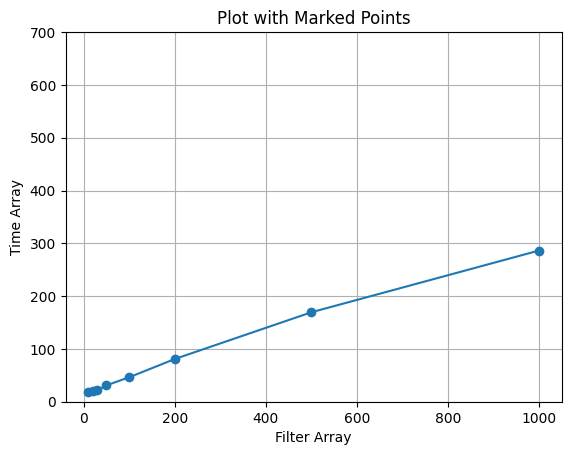

In [26]:
plt.plot(filter_arr, time_arr, marker='o', linestyle='-')  # 'o' marker style with solid line
plt.xlabel('Filter Array')
plt.ylabel('Time Array')
plt.ylim(0, 700)
plt.title('Plot with Marked Points')
plt.grid(True)  # Add grid lines
plt.show()